In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import required classes and packages
from keras_dgl.layers import GraphCNN #loading Graph Neural Network class
import keras.backend as K
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #loading tfidf vector
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential, load_model
import pickle
from keras.layers import Dense, Dropout, Activation, Flatten
import os
from sklearn.preprocessing import StandardScaler
from keras.layers import  MaxPooling2D
from keras.layers import Convolution2D
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
#loading drug side effects
side_effects = pd.read_csv("Dataset/Interaction_information.csv")
side_effects

,Description,side_effect_id
0,Drug1 can cause a decrease in the absorption o...,DDI type 0
1,Drug1 may increase the excretion rate of #Drug...,DDI type 16
2,Drug1 may increase the atrioventricular blocki...,DDI type 51
3,Drug1 may increase the hypoglycemic activities...,DDI type 64
4,Drug1 may increase the myopathic rhabdomyolysi...,DDI type 71
5,Drug1 may increase the respiratory depressant ...,DDI type 77


In [4]:
side_effects = side_effects.values

In [5]:
#function to get drug side effect description using ID
def getSideEffect(y_pred):
    label = "No Prediction"
    for i in range(len(side_effects)):
        if side_effects[i, 1].strip() == "DDI type "+str(y_pred).strip():
            label = side_effects[i,0]
            break
    return label  

In [6]:
#loading and displaying two sides drug bank dataset
dataset = pd.read_csv("Dataset/twosides_drugbank.csv")
Y = dataset['type'].ravel()#get drug side effect labels
dataset

,d1,d2,type,smiles1,smiles2
0,DB00390,DB00460,16,[H][C@]12CC[C@]3([H])[C@]([H])(C[C@@H](O)[C@]4...,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...
1,DB01396,DB00460,16,[H][C@]12CC[C@]3([H])[C@]([H])(CC[C@]4(C)[C@H]...,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...
2,DB01092,DB00460,16,[H][C@@]12CC[C@]3(O)C[C@H](C[C@@H](O)[C@]3(CO)...,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...
3,DB00375,DB00946,0,ClCC1CO1.NCCNCCNCCNCCN,CCC(C1=CC=CC=C1)C1=C(O)C2=C(OC1=O)C=CC=C2
4,DB09265,DB00682,0,[V].[H][C@](C)(O)[C@]([H])(N=C(O)CN=C(O)[C@]([...,CC(=O)CC(C1=CC=CC=C1)C1=C(O)C2=C(OC1=O)C=CC=C2
...,...,...,...,...,...
3904,DB01078,DB00992,16,C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)...,COC(=O)CCC(=O)CN
3905,DB01092,DB00992,16,[H][C@@]12CC[C@]3(O)C[C@H](C[C@@H](O)[C@]3(CO)...,COC(=O)CCC(=O)CN
3906,DB00390,DB09516,16,[H][C@]12CC[C@]3([H])[C@]([H])(C[C@@H](O)[C@]4...,COC1=CC=C(O)C=C1
3907,DB01092,DB09516,16,[H][C@@]12CC[C@]3(O)C[C@H](C[C@@H](O)[C@]3(CO)...,COC1=CC=C(O)C=C1


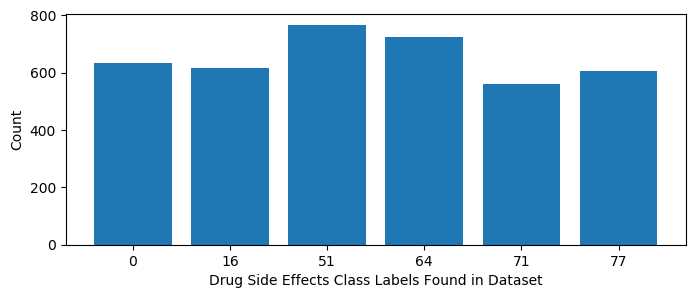

In [7]:
#Side effects ID found in Dataset
labels, count = np.unique(Y, return_counts=True)
#visualizing class labels count found in dataset
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (8, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Drug Side Effects Class Labels Found in Dataset")
plt.ylabel("Count")
plt.show()

In [8]:
#convert drug smile string into training vector so graph nodes can be created by GNN 
dataset.drop(['type'], axis = 1,inplace=True)
dataset = dataset.values
X = []
for i in range(len(dataset)):#loop all smiles string and then convert to vector
    X.append(dataset[i,0]+" "+dataset[i,1]+" "+dataset[i,2]+" "+dataset[i,3])
#convert each smile string into numeric vector
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm=None, decode_error='replace')
X = tfidf_vectorizer.fit_transform(X).toarray()
print("Generated Vector from Drug Smile stringr")
print(X)

Generated Vector from Drug Smile stringr
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.         10.38699884
   0.        ]]


In [9]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Train & Test Split Details")
print("80% Text data used to train algorithms : "+str(X_train.shape[0]))
print("20% Text data used to train algorithms : "+str(X_test.shape[0]))

Dataset Train & Test Split Details
80% Text data used to train algorithms : 3127
20% Text data used to train algorithms : 782


In [10]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [11]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(8, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

Existing KNN Accuracy  :  92.71099744245525
Existing KNN Precision : 93.03754072917269
Existing KNN Recall    : 92.49781929101725
Existing KNN FScore    : 92.56847782769717


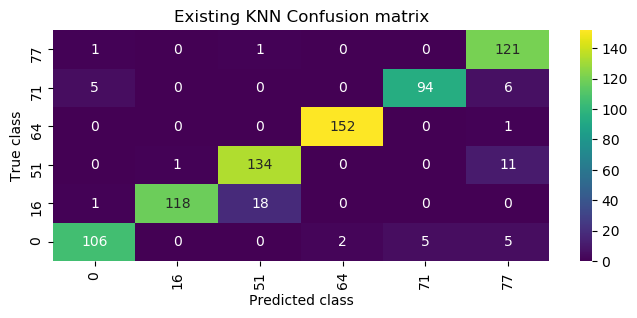

In [12]:
#train existing KNN algorithms using existing TF-IDF vector
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train, y_train)
#call this function to predict on test data
predict = knn.predict(X_test)
#call this function to calculate accuracy and other metrics
calculateMetrics("Existing KNN", predict, y_test)

Existing Decision Tree Accuracy  :  96.80306905370844
Existing Decision Tree Precision : 96.83228251889693
Existing Decision Tree Recall    : 96.91572144805386
Existing Decision Tree FScore    : 96.86272470460167


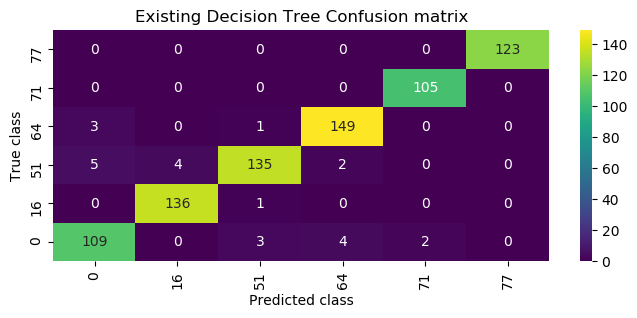

In [13]:
#train existing Decision Tree algorithms using DRUG vector
dt_cls = DecisionTreeClassifier()
dt_cls.fit(X_train, y_train)
#call this function to predict on test data
predict = dt_cls.predict(X_test)
#call this function to calculate accuracy and other metrics
calculateMetrics("Existing Decision Tree", predict, y_test)


Propose GNN Algorithm Accuracy  :  97.3145780051151
Propose GNN Algorithm Precision : 97.62770211432316
Propose GNN Algorithm Recall    : 97.35879645694885
Propose GNN Algorithm FScore    : 97.40160796919226


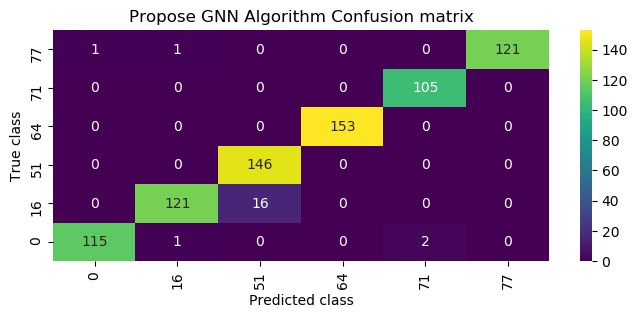

In [14]:
#train propose GNN algorithm using drug vector
#train GNN model by uisng GraphCNN class from keras
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
graph_conv_filters = np.eye(1)
graph_conv_filters = K.constant(graph_conv_filters)
gnn_model = Sequential()
#define GNN layer to build graph from input features and then trained a model
gnn_model.add(GraphCNN(128, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
gnn_model.add(GraphCNN(64, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
#adding variational autoencoder to avoid overfitting
gnn_model.add(GraphCNN(1, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
#defining output layer
gnn_model.add(Dense(units = 256, activation = 'relu'))
gnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
gnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#compile and train the model
if os.path.exists("model/gnn_weights.h5") == False:
    hist = gnn_model.fit(X_train, y_train1, batch_size=1, epochs=10, validation_data = (X_test, y_test1), verbose=1)
    gnn_model.save_weights("model/gnn_weights.h5")
    f = open('model/gnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    gnn_model.load_weights("model/gnn_weights.h5")
#define predict function to perform prediction on test data and calculate accuracy and other metrics
pred = []
for i in range(len(X_test)):
    temp = []
    temp.append(X_test[i])
    temp = np.asarray(temp)
    #call this function to predict on test data
    predict = gnn_model.predict(temp, batch_size=1)
    predict = np.argmax(predict)
    pred.append(predict)
predict = np.asarray(pred)    
y_test2 = np.argmax(y_test1, axis=1)  
#call this function to calculate accuracy and other metrics
calculateMetrics("Propose GNN Algorithm", predict, y_test2)


Extension CNN2D Algorithm Accuracy  :  99.74424552429667
Extension CNN2D Algorithm Precision : 99.73917103073114
Extension CNN2D Algorithm Recall    : 99.77168949771689
Extension CNN2D Algorithm FScore    : 99.7541279226133


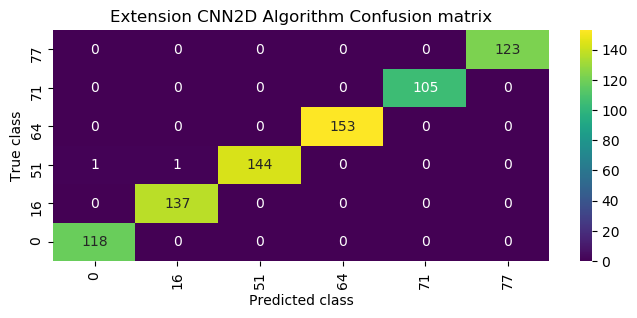

In [15]:
#defining extension CNN2D algorithm with dropout layer to remove irrelevant features while training so CNN2D can trained
#on best optimized features to enhnace accuracy
#CNN2D is a multidimensional neural network which trained in multidimension features to analyse all weights from vector
#and then trained model using best features
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
#training CNN2D algorithm on graph vector features
extension_model = Sequential()
extension_model.add(Convolution2D(32, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (1, 1)))
extension_model.add(Dropout(0.3))
extension_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (1, 1)))
extension_model.add(Dropout(0.3))
extension_model.add(Flatten())
extension_model.add(Dense(units = 256, activation = 'relu'))
extension_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train1, y_train1, batch_size = 16, epochs = 10, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model.load_weights("model/extension_weights.hdf5")
#call this function to predict on test data     
predict = extension_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("Extension CNN2D Algorithm", predict, y_test2)

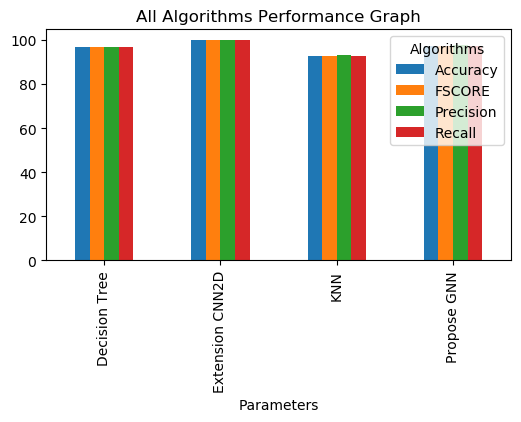

In [16]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['KNN','Accuracy',accuracy[0]],['KNN','Precision',precision[0]],['KNN','Recall',recall[0]],['KNN','FSCORE',fscore[0]],
                   ['Decision Tree','Accuracy',accuracy[1]],['Decision Tree','Precision',precision[1]],['Decision Tree','Recall',recall[1]],['Decision Tree','FSCORE',fscore[1]],
                   ['Propose GNN','Accuracy',accuracy[2]],['Propose GNN','Precision',precision[2]],['Propose GNN','Recall',recall[2]],['Propose GNN','FSCORE',fscore[2]],
                   ['Extension CNN2D','Accuracy',accuracy[3]],['Extension CNN2D','Precision',precision[3]],['Extension CNN2D','Recall',recall[3]],['Extension CNN2D','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [17]:
#display all algorithm performnace
algorithms = ['Existing KNN', 'Existing Decision TRee', 'Propose GNN', 'Extension CNN2D']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Existing KNN,92.710997,93.037541,92.497819,92.568478
1,Existing Decision TRee,96.803069,96.832283,96.915721,96.862725
2,Propose GNN,97.314578,97.627702,97.358796,97.401608
3,Extension CNN2D,99.744246,99.739171,99.771689,99.754128


In [18]:
#function to read test data and then predict side effects
testData = pd.read_csv("Dataset/testData.csv")#read Test Data
testData = testData.values
test = []
for i in range(len(testData)):#create array of smile string
    test.append(testData[i,0]+" "+testData[i,1]+" "+testData[i,2]+" "+testData[i,3])
test = tfidf_vectorizer.transform(test).toarray()#convert array of smile string into vector
test = np.reshape(test, (test.shape[0], test.shape[1], 1, 1))
predict = extension_model.predict(test)#apply extension CNN2D model to predict side effects from given drug smile string vector
for i in range(len(predict)):
    y_pred = np.argmax(predict[i])
    print("Test Data = "+str(testData[i])+" Predicted Sife Effect ===> "+getSideEffect(y_pred))
    print()

Test Data = ['DB01501' 'DB00765'
 'OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)CC1)C1=CC=CC=C1'
 'C[C@](N)(CC1=CC=C(O)C=C1)C(O)=O'] Predicted Sife Effect ===> Drug1 may increase the respiratory depressant activities of #Drug2.

Test Data = ['DB01370' 'DB01044' '[Al]'
 'COC1=C2N(C=C(C(O)=O)C(=O)C2=CC(F)=C1N1CCNC(C)C1)C1CC1'] Predicted Sife Effect ===> Drug1 can cause a decrease in the absorption of #Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.

Test Data = ['DB06739' 'DB01044' 'CC1=C(C)C(=O)C(C(CCCCCC(O)=O)C2=CC=CC=C2)=C(C)C1=O'
 'COC1=C2N(C=C(C(O)=O)C(=O)C2=CC(F)=C1N1CCNC(C)C1)C1CC1'] Predicted Sife Effect ===> Drug1 may increase the myopathic rhabdomyolysis activities of #Drug2.

Test Data = ['DB01708' 'DB00887'
 '[H][C@@]12CCC(=O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC=C2C[C@@]([H])(O)CC[C@]12C'
 'CCCCNC1=C(OC2=CC=CC=C2)C(=CC(=C1)C(O)=O)S(N)(=O)=O'] Predicted Sife Effect ===> Drug1 may increase the hypoglycemic activities of #Drug2.

Test Dat